# Analyse stochastic simulations of linear feedback control

Author: Juvid Aryaman

In [1]:
import mitonetworks.det as mtd
import mitonetworks.stoch as mts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter('ignore',UserWarning)

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
mts.reset_plots()
fontsize = 30
font = {'size' : fontsize}
plt.rcParams.update({'axes.labelsize': fontsize})

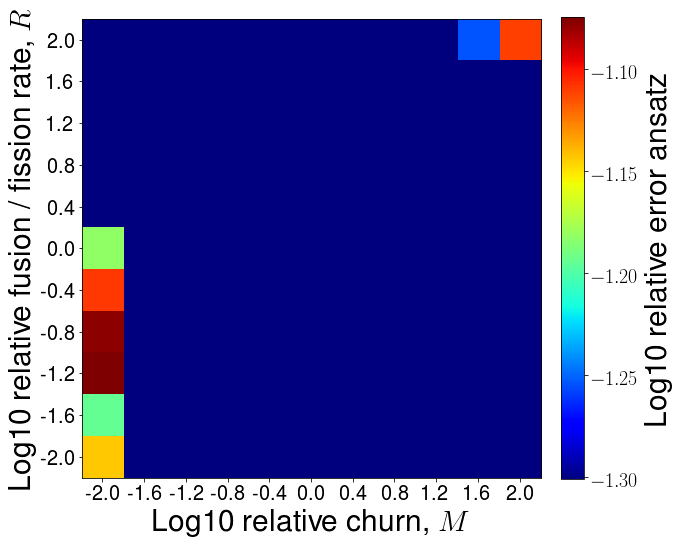

In [5]:
istransposed = False       
ansatz_is_ajhg = False # control is in replication rate

analysis = mts.AnalyseDataFeedbackControl(dir_df_params = '../../param_sweep_vals.csv',
        dir_data = '../Data/', ctrl_name = 'lfc',  istransposed=istransposed, 
        ansatz_is_ajhg = ansatz_is_ajhg, 
        plotextensions=['png']
)
    

analysis.make_gradients()
analysis.compute_errors()
    
analysis.make_heatmap(matrix=analysis.error_ansatz_beta_gamma, vmin=np.log10(0.05), 
                  zlabel='Log10 relative error ansatz', figname='ansatz_err_net_sweep');
    

In [6]:
mts.reset_plots()

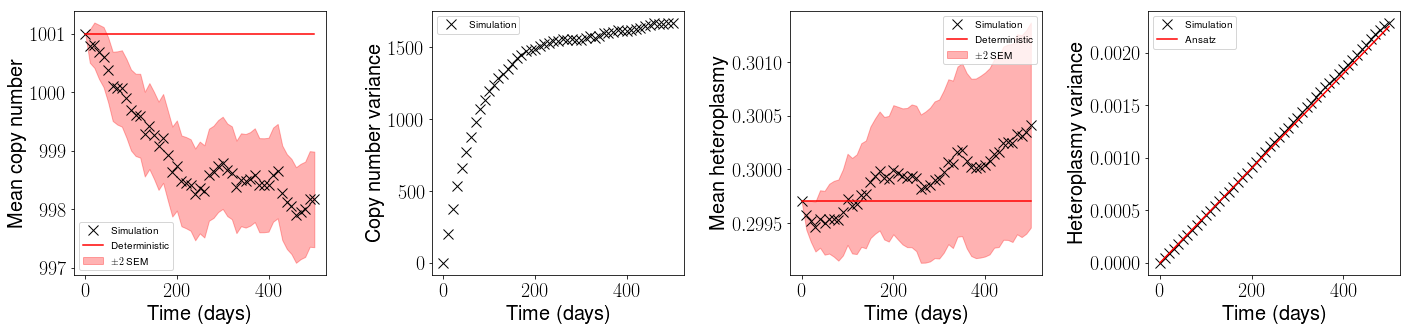

In [7]:
analysis.plot_h_n_t(60, figname='traj');

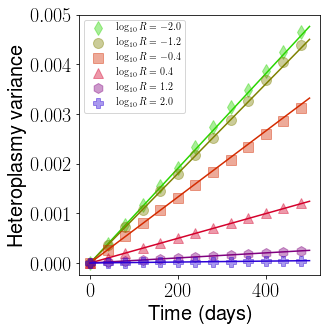

In [8]:
nom_df = analysis.df_params[analysis.df_params['net_mag'] == 1.0]
nom_ind = nom_df.index[::2]
nom_M = np.log10(nom_df['net_rat'])[::2]
leg_list = [r"$\log_{{10}}{{R}}={:.1f}$".format(i) for i in nom_M]
analysis.plot_vh_param_sw(nom_ind, leg_list,figname="R_sw_lfc",sparsify_data=True)

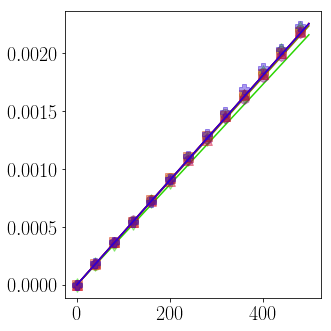

In [9]:
nom_df = analysis.df_params[analysis.df_params['net_rat'] == 1.0]
nom_ind = nom_df.index[::2]
nom_M = np.log10(nom_df['net_mag'])[::2]
leg_list = [r"$\log_{{10}}{{M}}={:.1f}$".format(i) for i in nom_M]
analysis.plot_vh_param_sw(nom_ind, leg_list,figname="M_sw_lfc", plot_legend = False, plot_labels=False,sparsify_data=True)